In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [2]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/data'

# Data Preprocessing

In [3]:
# facility trace
df_ftrace = pd.read_csv(f"{epi_dir}/2019-12-18_facility_trace.csv", index_col=0)
df_ftrace.columns = np.arange(367)

# recover facility trace
ftrace = (df_ftrace > 0).astype(int)

# recover infections
# how does this handle people who are 
infections = df_ftrace.replace(1, np.nan).ffill(axis=1)
infections = infections.replace({0:np.nan, 1.25:0, 1.5:1})

106


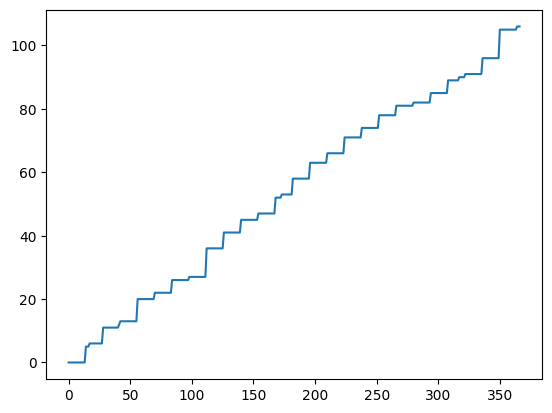

In [337]:
# how many infection events occur after admission?
new_infections = (infections.diff(axis=1) == 1).astype(int).sum(0)
print(new_infections.sum())
sns.lineplot(new_infections.cumsum())
plt.show()

In [336]:
# how many infections happen upon admission?
# infections

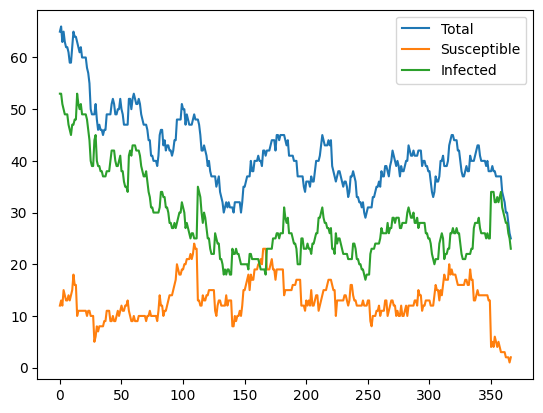

In [19]:
I = infections.sum(0)
N = ftrace.sum(0)
S = N - I
sns.lineplot(N, label="Total")
sns.lineplot(S, label="Susceptible")
sns.lineplot(I, label="Infected")
plt.show()

In [341]:
# deal with: people who get infected twice!
# are there many?
# new goal: assume someone can't recover during a stay
# but they may leave and come back recovered (?)
infections_cleaned = infections.copy()
doubles = set()
for i, row in infections_cleaned.iterrows():
    infected = False
    for j, v in row.items():
        if infected:
            if v == 0:
                doubles.add(i)
                row[j] = 1
        if v == 1:
            infected = True
        if np.isnan(v):
            infected = False

print(list(doubles))

[162, 295, 13, 155, 92]


In [76]:
n_visits = {}
for i, row in infections_cleaned.iterrows():
    admitted = False
    z = 0
    for _, v in row.items():
        if not np.isnan(v) and not admitted:
            admitted = True
            z += 1
        if np.isnan(v):
            admitted = False
    n_visits[i] = z
n_visits = pd.Series(n_visits)

In [79]:
n_visits.value_counts() / len(n_visits)

1    0.723077
2    0.184615
3    0.057692
4    0.026923
5    0.007692
Name: count, dtype: float64

In [426]:
n_visits.sum()

367

In [84]:
ftrace.sum(1).describe()

count    260.000000
mean      59.061538
std       54.894107
min        2.000000
25%       22.750000
50%       43.000000
75%       73.250000
max      272.000000
dtype: float64

One possible issue: the data makes it seem like we start off with an unusually high number of infections. Maybe we can ameliorate this by starting 100 days into the year...seems easier than modeling a time-varying pre-admitted colonization rate

Or, we hardcode initial infections (back to the original plan)

### Understanding precolonization

In [404]:
first_test = {}
for i, r in df_ftrace.reset_index(drop=True).iterrows():
    entry_time = 0
    entered = False
    for j, v in r.items():
        if v > 0 and not entered:
            entry_time = j
            entered = True
        if v > 1:
            first_test[i] = j - entry_time
            break
first_test = pd.Series(first_test)           

In [406]:
first_test.value_counts()

0     145
1      93
2       7
3       4
13      2
11      2
14      1
7       1
4       1
22      1
5       1
8       1
12      1
Name: count, dtype: int64

In [408]:
# more than 90% of people are tested within a day of arrival
(145 + 93) / 260

0.9153846153846154

In [409]:
# how about multiple visits...

In [430]:
first_test = {}
i = 0
for _, r in df_ftrace.reset_index(drop=True).iterrows():
    entry_time = 0
    entered = False
    recorded = False
    for j, v in r.items():
        if v > 0 and not entered:
            entry_time = j
            entered = True
        if entered and v == 0:
            i += 1
            entered = False
            recorded = False
        if v > 1 and not recorded:
            first_test[i] = j - entry_time
            recorded = True
    if entered:
        i += 1
first_test = pd.Series(first_test)      

In [445]:
first_test.value_counts() / 367

0     0.534060
1     0.926431
2     0.950954
3     0.961853
13    0.967302
4     0.972752
5     0.978202
11    0.983651
14    0.986376
7     0.989101
22    0.991826
28    0.994550
8     0.997275
12    1.000000
Name: count, dtype: float64

build dataframe of colonizations upon arrival

what i'll do--if someone gets tested within 3 days of arrival (95% of first tests)

In [447]:
df_precol.loc[1, 360]

nan

In [ ]:
# assume susceptible unless proven otherwise?

In [ ]:
df_precol = pd.DataFrame(index=df_ftrace.index, columns=df_ftrace.columns)
for n, r in df_ftrace.iterrows():
    entry_time = 0
    entered = False
    recorded = False
    for t, v in r.items():
        if v > 0 and not entered:
            entry_time = t
            entered = True
        if entered and v == 0:
            entered = False
            recorded = False
        if v > 1 and not recorded:
            test_time = j - entry_time
            if test_time 
            first_test[i] = j - entry_time
            recorded = True
    if entered:
        i += 1

In [438]:
a = df_ftrace.loc[2].values

In [443]:
(a == 1).argmax()

153

In [444]:
(infections_cleaned.loc[2].values == 0).argmax()

154

## \\\\\\\\\\
Simulator I: Random pre-colonization

In [233]:
def crkp_simulator(params, seed):
    np.random.seed(seed)
    N, T = ftrace.shape
    alpha = params[0]
    beta = np.exp(params[1])
    
    W = ftrace.values
    # old admitted status
    w = np.zeros(N)
    
    X = np.empty((N, T))
    # old infection status
    x = np.empty(N)
    x[:] = np.nan
    
    I = np.zeros(N)
    
    for t in range(T):
        # case 1: not present
        # if absent, set to nan
        # otherwise, inherit old status
        X[:, t] = np.where(1 - W[:, t], np.nan, x)
        # case 2: new arrival
        newly_admitted = W[:, t] * (1 - w)
        # if newly admitted, simulate positive or negative arrival
        # otherwise, inherit old status (positive, negative, absent)
        X[:, t] = np.where(newly_admitted, np.random.binomial(1, alpha, N), X[:, t])
        # ALTERNATIVELY
        # inherit infection statuses from ground truth
        # case 3: already admitted and susceptible
        # randomly model transmission event
        # otherwise, inherit old status
        staying = W[:, t] * w
        hazard = I.sum() * beta * np.ones(N)
        p = 1 - np.exp(-hazard / N) # not the end of the world to normalize by size of population
        X[:, t] = np.where(staying * (1 - I), np.random.binomial(1, p, N), X[:, t])
        x = X[:, t]
        w = W[:, t]
        I = (x == 1).astype(int)

    return np.nansum(X, axis=0) / N

## Simulator II: Fixed Precolonization

## ABC First Pass

In [243]:
def accept_sample(x, x_o, epsilon, summarize):
    # error should have dimension (d_theta, d_x)
    # if summarize:
    #     x_o = x_o[:, 0]
    # w = 1 if len(x_o) > 1 else None
    v = np.array(x - x_o)
    # TODO: introduce scaling
    error = np.linalg.norm(v)
    # if not summarize:
    #     error = error.mean(w)
    accept = (error < epsilon)
    # if accept.dim() > 0:
    #     accept = accept.min()
    return accept, error

In [223]:
def abc_rejection_sampler(S, epsilon, prior_sampler, simulator, 
                          x_o, max_attempts=10000, summarize=False):
    # S: total number of particles
    samples = []
    attempts = 0
    # x_o = x_o.transpose(0,1)
    # x_o is shape (d_theta, d_x)
    errors = np.full(max_attempts, -1e3)
    start_time = timer()
    for s in range(S):
        accept = False
        while not accept:
            theta = prior_sampler()
            x = simulator(theta, seed=attempts)
            accept, error = accept_sample(x, x_o, epsilon, summarize)
            if accept:
                samples.append(theta)
            errors[attempts] = error
            attempts += 1
            if attempts == max_attempts:
                print("Maximum attempts reached, halting")
                return np.array(samples), errors
            if not attempts % 1000:
                print(f"Attempts: {attempts:,}")
    end_time = timer()
    accept_rate = S / attempts
    
    print(f"Time lapsed: {end_time - start_time:.2f} seconds")
    print(f"With tolerance {epsilon}, acceptance rate: {accept_rate:.6f}")
    print(f"Total number of attempts: {attempts:,}")
    return np.array(samples), errors

In [248]:
# set a uniform prior of [0.1, 0.9] on alpha
# set a normal prior of (-3, 1) on beta
def prior_sampler():
    alpha = np.random.uniform(0.1, 0.9)
    logbeta = np.random.normal(-3, 1)
    return np.array([alpha, logbeta])

In [318]:
x_o = infections_cleaned.sum(0) / N

S = 100
eps = .33

posterior_sample, errors = abc_rejection_sampler(
    S, eps, prior_sampler, crkp_simulator, x_o, max_attempts=100000,
    summarize=False
    )

Attempts: 1,000
Attempts: 2,000
Attempts: 3,000
Time lapsed: 31.65 seconds
With tolerance 0.33, acceptance rate: 0.031358
Total number of attempts: 3,189


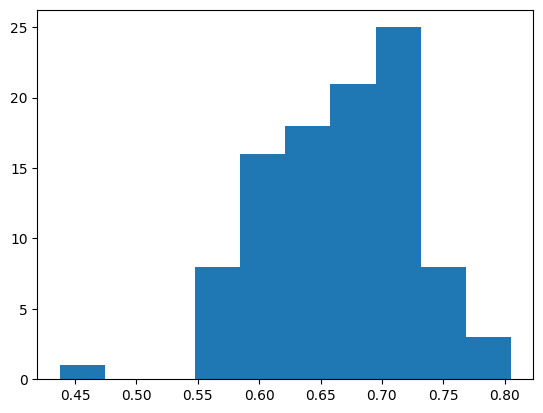

In [328]:
plt.hist(posterior_sample[:,0])
plt.show()

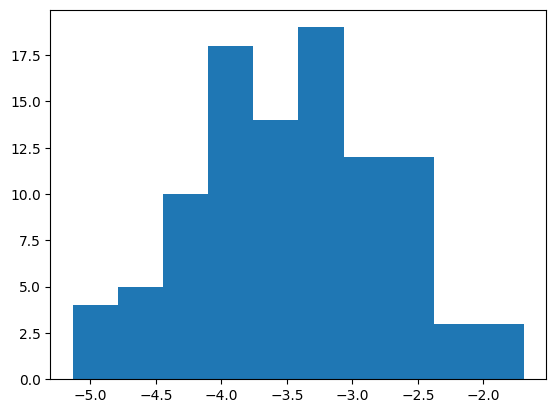

In [329]:
plt.hist(posterior_sample[:,1])
plt.show()

#### posterior predictive check

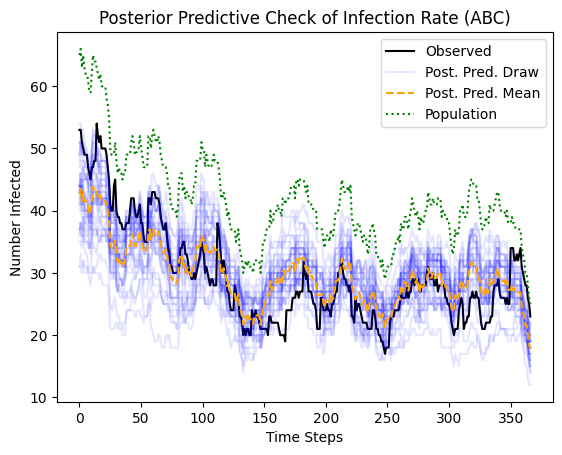

In [330]:
K = 30
Nt = ftrace.sum().values
posterior_predictive_abc = np.empty((K, T))
for i in range(30):
    alpha = posterior_sample[i][0]
    beta = posterior_sample[i][1]
    x_rep = crkp_simulator([alpha, beta], i)
    posterior_predictive_abc[i] =  np.array(x_rep) * N
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o * N
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.plot(Nt, label="Population", color="g", linestyle=":")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Number Infected")
plt.xlabel("Time Steps")
plt.show()

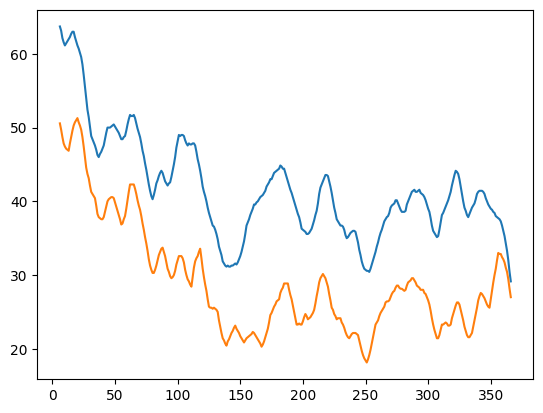

In [460]:
I_o = x_o * N

n_smooth = pd.Series(Nt).rolling(7).mean()
plt.plot(n_smooth)
i_smooth = I_o.rolling(7).mean()
plt.plot(i_smooth)
plt.show()

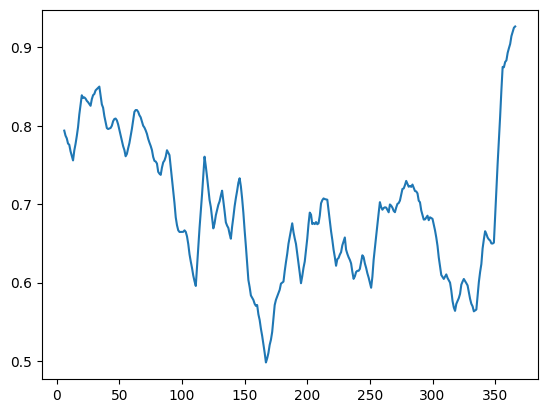

In [461]:
plt.plot(i_smooth / n_smooth)

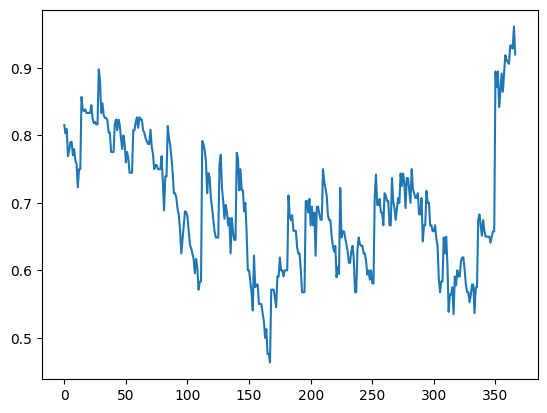

In [462]:
plt.plot(I_o / Nt)

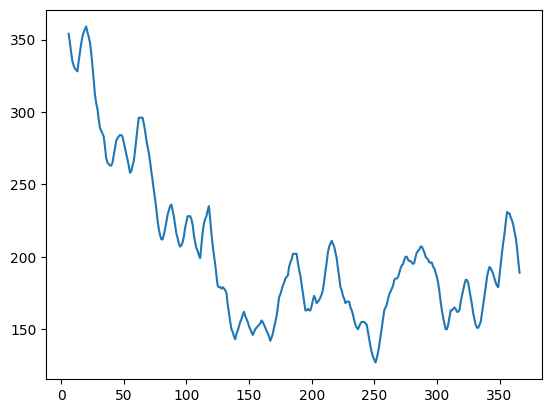

In [454]:
plt.plot(I_o.rolling(7).sum())

In [ ]:
plt.plot(I_o, label="Observed", color="k")

In [331]:
posterior_sample.mean(0)[0]

0.6634184512564246

In [332]:
np.exp(posterior_sample.mean(0)[1])

0.03174023477330067

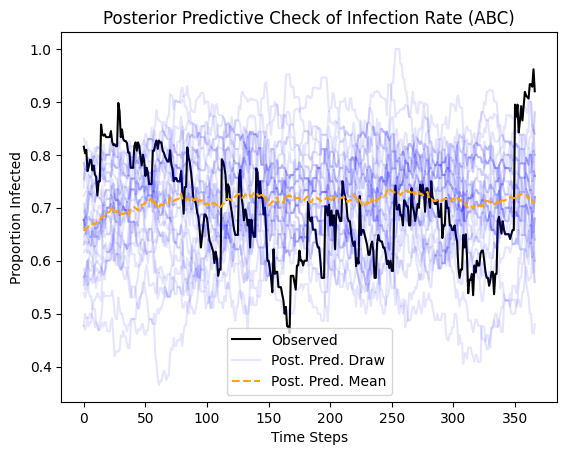

In [349]:
K = 30
Nt = ftrace.sum().values
posterior_predictive_abc = np.empty((K, T))
for i in range(30):
    alpha = posterior_sample[i][0]
    beta = posterior_sample[i][1]
    x_rep = crkp_simulator([alpha, beta], i)
    posterior_predictive_abc[i] =  np.array(x_rep) * N / Nt
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o * N / Nt
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(Nt, label="Population", color="g", linestyle=":")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

Interpretation: this isn't actually that meaningful, right? This model assigns most of the explanatory power to people entering the LTACH with CRKP, the transmission rate is relatively low. At least when you average out, the time-varying effects seem negligible. Slight uptick in the proportion infected over time